In [69]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import csv
import pprint as pprint
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

from datetime import datetime
from matplotlib.ticker import MultipleLocator
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency
from scipy.stats import chi2

%matplotlib inline

red = 'C3'
blue = 'C0'
legend = ['Russian Trolls', 'Non-Russian Trolls']

def read_csv(filename, names):
    df = pd.read_csv(filename, 
        delimiter='\t',
        names=names,
        quoting=csv.QUOTE_NONE)
    return df

def normalise_total(df, y):
    total = df[y].sum()
    df[y] = df[y] / total
    return df

def convert_to_percentage(df, y):
    df[y] *= 100
    return df

def to_moscow_time(df, df_hour):
    # times are originally GMT+0
    df[df_hour] = (df[df_hour] + 3) % 24
    return df

def get_normalised_date_sorted_csv(filename, col_names):
    date = col_names[0]
    counts = col_names[1]
    
    df = read_csv(filename, col_names)
    df = sort_by_date(df, date)
    df[date] = [datetime.strptime(x, '%d %m %Y') for x in df[date]]
    df = normalise_total(df, counts)
    return df

def sort_by_date(df, date):
    df['day'], df['month'], df['year'] = df[date].str.split(' ', 0).str
    df = df.sort_values(['year', 'month', 'day'])
    return df

def get_normalised_hmy_sorted_csv(filename, col_names):
    hmy = col_names[0]
    counts = col_names[1]
    
    df = read_csv(filename, col_names)
    
    df['hour'], df['month'], df['year'] = df[hmy].str.split(' ', 0).str
    df['hour'] = pd.to_numeric(df['hour'])
    df = to_moscow_time(df, 'hour')
    df = df.sort_values(['year', 'month', 'hour'])
    
    df[hmy] = df['year'].map(str) + '-' + df['month']
    df[hmy] = [datetime.strptime(x, '%Y-%m') for x in df[hmy]]
    
    df = normalise_total(df, counts)
    return df

def get_my_csv(filename, col_names):
    my = col_names[0]
    norm_counts = col_names[1]
    
    df = read_csv(filename, col_names)
    
#     df[my] = [datetime.strptime(x, '%Y-%m') for x in df[my]]
    return df

def plot_russian_vs_normal_bar(df_russian, df_normal,
                               df_x, df_y, 
                               label_x, label_y, title=None, 
                               y_min=None, y_max=None, filename=None):
    fig,ax = plt.subplots()
    
    ax.bar(df_russian[df_x], df_russian[df_y], width=0.6, color=red, edgecolor='black')
    ax.bar(df_normal[df_x], df_normal[df_y], width=0.6, color=blue, edgecolor='black')
    if title != None:
        ax.set_title(title)
    ax.set_xticklabels(legend)
    
    if y_min != None and y_max != None:
        plt.ylim(y_min, y_max)
    elif y_min != None:
        plt.ylim(bottom=y_min)
    elif y_max != None:
        plt.ylim(top=y_max)
    
    plt.xlim([-1, 2])
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.tight_layout()
    
    if filename != None:
        fig.savefig('viz/'+filename+'.svg', bbox_inches='tight')
    plt.show()
    
    
def plot_russian_vs_normal_line(df_russian, df_normal, 
                                df_x, df_y,
                                label_x, label_y,
                                title=None,
                                is_date=False, has_legend=True,
                                is_day_date=False, set_label_x=True, set_label_y=True,
                                y_min=None, y_max=None, bbox_to_anchor=(1,1),
                                linewidth=1.5, loc="best", filename=None): 
        fig, ax = plt.subplots()

        if title != None:
            ax.set_title(title)       
        if set_label_x:
            plt.xlabel(label_x)
        if set_label_y:
            plt.ylabel(label_y)
        
        for r in df_russian:
            ax.plot(r[df_x], r[df_y], red, linewidth=linewidth)
        
        for n in df_normal:
            ax.plot(n[df_x], n[df_y], blue, linewidth=linewidth)     
        
        if has_legend:
            ax.legend(legend, loc=loc, bbox_to_anchor=bbox_to_anchor)
            leg = ax.get_legend()
            leg.legendHandles[0].set_color(red)
            leg.legendHandles[1].set_color(blue)

        if is_date:
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
#             plt.gca().xaxis.set_major_locator(mdates.MonthLocator([1, 5, 9]))   
            plt.gcf().autofmt_xdate()
        elif is_day_date:
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
            plt.gcf().autofmt_xdate()
        else:
            ax.xaxis.set_ticks(np.arange(0, 24, 4))
            ax.xaxis.set_minor_locator(MultipleLocator(1))   
        
        if y_min != None and y_max != None:
            plt.ylim(y_min, y_max)
        elif y_min != None:
            plt.ylim(bottom=y_min)
        elif y_max != None:
            plt.ylim(top=y_max)

        ax.margins(x=0.01)
#         plt.tight_layout()
#         plt.grid()
        if filename != None:
            fig.savefig('viz/'+filename+'.svg', bbox_inches='tight')
        plt.show()
        

def plot_russian_vs_normal_scatter(df_russian, df_normal, 
                                df_x, df_y,
                                label_x, label_y,
                                title=None,
                                is_date=False, has_legend=True,
                                is_day_date=False, set_label_x=True, set_label_y=True,
                                y_min=None, y_max=None, bbox_to_anchor=(1,1),
                                linewidth=1.5, loc="best", filename=None): 
        fig = plt.figure(figsize=(5, 6))
        grid = plt.GridSpec(2, 1, hspace=0.05, height_ratios=[1, 1])
        russian_sub = fig.add_subplot(grid[0])
        normal_sub = fig.add_subplot(grid[0])
        
        russian_com = fig.add_subplot(grid[1])
        normal_com = fig.add_subplot(grid[1])
        
        if title != None:
            ax.set_title(title)
        if set_label_x:
            plt.xlabel(label_x)
        if set_label_y:
            plt.ylabel(label_y)
            russian_com.get_yaxis().set_label_coords(-0.1, 1)
        
        alpha=0.5
        s=7
        
        axes_russian = [russian_sub, russian_com]
        axes_normal = [normal_sub, normal_com]
        
        for ax, df in zip(axes_russian, df_russian):
            for r in df: 
                ax.scatter(r[df_x], r[df_y], color=red, alpha=alpha, s=s)
                ax.plot(r[df_x], r[df_y], color=red, linewidth=linewidth)
        
        for ax, df in zip(axes_normal, df_normal):
            for n in df: 
                ax.scatter(n[df_x], n[df_y], color=blue, alpha=alpha, s=s)
                ax.plot(n[df_x], n[df_y], color=blue, linewidth=linewidth)    
        
        plt.setp(russian_sub.get_xticklabels(), visible=False)
        
        if has_legend:
            ax.legend(legend, loc=loc, bbox_to_anchor=bbox_to_anchor)
            leg = ax.get_legend()
            leg.legendHandles[0].set_color(red)
            leg.legendHandles[1].set_color(blue)

        if is_date:
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
#             plt.gca().xaxis.set_major_locator(mdates.MonthLocator([1, 5, 9]))   
            plt.gcf().autofmt_xdate()
        else:
            ax.xaxis.set_ticks(np.arange(0, 24, 4))
            ax.xaxis.set_minor_locator(MultipleLocator(1))   
        
        if y_min != None and y_max != None:
            plt.ylim(y_min, y_max)
        elif y_min != None:
            plt.ylim(bottom=y_min)
        elif y_max != None:
            plt.ylim(top=y_max)

#         plt.tight_layout()
        ax.margins(x=0.01)
        if filename != None:
            fig.savefig('viz/'+filename+'.svg', bbox_inches='tight')
        plt.show()
        
    
def plot_cdf_double(df_russian, df_normal, 
                    df_x, df_y,
                    label_x,
                    title=None,
                    log_scale=False, has_legend=True,
                    set_label_x=True, set_label_y=True,
                    y_min=None, y_max=None, filename=None):
    fig, ax = plt.subplots()
    
    russian = df_russian.sort_values(df_y)[df_y].tolist()
    yvals = np.arange(len(russian))/float(len(russian)-1)
    ax.plot(russian, yvals, color=red)
    
    normal = df_normal.sort_values(df_y)[df_y].tolist()   
    yvals = np.arange(len(normal))/float(len(normal)-1)
    ax.plot(normal, yvals, color=blue)
    
    if has_legend:
        ax.legend(legend, loc="lower right")
        leg = ax.get_legend()
        leg.legendHandles[0].set_color(red)
        leg.legendHandles[1].set_color(blue)
    
    if (log_scale):
        ax.set_xscale("log")
        
    if title != None:
        ax.set_title(title)
        
    if set_label_x:
        plt.xlabel(label_x)
    if set_label_y:
        plt.ylabel('CDF')
    plt.grid()
    
    if y_min != None and y_max != None:
        plt.ylim(y_min, y_max)
    elif y_min != None:
        plt.ylim(bottom=y_min)
    elif y_max != None:
        plt.ylim(top=y_max)
    
    if filename != None:
        fig.savefig('viz/'+filename+'.svg', bbox_inches='tight')
    plt.show()
    

def plot_cdf_single(counts, label_x=None, 
                    title=None,
                    log_scale=False, 
                    x_min=None, x_max=None, filename=None):
    counts.sort()
    fig, ax = plt.subplots()
    yvals = np.arange(len(counts))/float(len(counts)-1)
    ax.plot(counts, yvals)
    
    if (log_scale):
        ax.set_xscale("log")
    
    if x_min != None and x_max != None:
        plt.xlim(x_min, x_max)
    elif x_min != None:
        plt.xlim(bottom=x_min)
    elif x_max != None:
        plt.xlim(top=x_max)
    
    if title != None:
        ax.set_title(title)
    if label_x != None:
        plt.xlabel(label_x)
    plt.ylabel('CDF')
    plt.grid()
    plt.tight_layout()
    if filename != None:
        fig.savefig('viz/'+filename+'.svg', bbox_inches='tight')
    plt.show()
    

def plot_bar(df,  
             df_x, df_y, 
             label_x, label_y,
             title=None,
             y_min=None, y_max=None, filename=None):
    plt.bar(df[df_x], df[df_y], width=0.6, color=blue, edgecolor='black')
    if title != None:
        plt.set_title(title)
    
    if y_min != None and y_max != None:
        plt.ylim(y_min, y_max)
    elif y_min != None:
        plt.ylim(bottom=y_min)
    elif y_max != None:
        plt.ylim(top=y_max)
    
    plt.xlim([-1, len(df[df_x])])
    plt.xlabel(label_x)
    plt.xticks(rotation=90)
    plt.ylabel(label_y)
    plt.tight_layout()
    
    if filename != None:
        fig = plt.figure()
        fig.savefig('viz/'+filename+'.svg', bbox_inches='tight')
    plt.show()
    

def plot_hbar(df, 
             df_x, df_y, 
             label_y, label_x=None,
             set_label_y=True,
             title=None, filename=None):
    fig, ax = plt.subplots()
    y_pos = np.arange(len(df))
    
    ax.barh(df[df_x], df[df_y], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df[df_x])
    if label_x != None:
        ax.set_xlabel(label_x)
    if set_label_y:
        ax.set_ylabel(label_y)
    if title != None:
        ax.set_title(title)
    ax.margins(y=0.01)
    
    plt.tight_layout()
    
    if filename != None:
        fig.savefig('viz/'+filename+'.svg', bbox_inches='tight')
    
    
def get_df_by_period(df, df_x, start_year, start_month, end_year, end_month):
    df_by_period = []
    
    current_year = start_year
    current_month = start_month
    while True:
        str_current_year = str(current_year)
        str_current_month = str(current_month) if current_month >= 10 else '0' + str(current_month)
        str_year_month = str_current_year + '-' + str_current_month
        
        df_by_period.append(df.loc[(str_year_month == df[df_x])])
        
        current_month += 1
        if current_year == end_year and current_month > end_month:
            break

        if current_month >= 12:
            current_year += 1
            current_month = 1
 
    return df_by_period

def plot_hist(df,  
              df_x, df_y, 
              label_x=None, label_y=None,
              title=None,
              y_min=None, y_max=None, x_min=0.000001, x_max=1.0, filename=None):
    plt.hist(df[df_y], bins=np.logspace(np.log10(x_min), np.log10(x_max), 50))
    plt.gca().set_xscale('log')
    if label_y != None:
        plt.ylabel(label_y)
    if label_x != None:
        plt.xlabel(label_x)
    if title != None:
        plt.title(title)
    plt.tight_layout()
    if filename != None:
        fig = plt.gcf()
        fig.savefig('viz/'+filename+'.svg', bbox_inches='tight')
        
    plt.show()
    
def plot_hist_single_cdf(df,  
              df_x, df_y, 
              label_x=None, label_y=True,
              title=None,
              y_min=None, y_max=None, x_min=0.000001, x_max=1.0, filename=None):
    
    counts = df[df_y].tolist()
    counts.sort()
    
    yvals = np.arange(len(counts))/float(len(counts)-1)

    fig = plt.figure(figsize=(5, 6))
    grid = plt.GridSpec(2, 1, hspace=0.05, height_ratios=[1, 1])
    hist = fig.add_subplot(grid[0])
    cdf = fig.add_subplot(grid[1])
    
    hist.hist(df[df_y], bins=np.logspace(np.log10(x_min), np.log10(x_max), 50)) 
    hist.set_xscale('log')
    hist.set_xlim(x_min, x_max)
    plt.setp(hist.get_xticklabels(), visible=False)
    
    cdf.plot(counts, yvals)
    cdf.set_xscale("log")
    cdf.set_xlim(x_min, x_max)
    cdf.grid()
    
    if label_y:
        cdf.set_ylabel('CDF')
        hist.set_ylabel('Frequency')
#     else:
#         plt.setp(cdf.get_yticklabels(), visible=False)
    
    if title != None:
        ax.set_title(title)
    if label_x != None:
        plt.xlabel(label_x)

    if filename != None:
        fig.savefig('viz/'+filename+'.svg', bbox_inches='tight')
    plt.show()

def plot_hist_double_cdf(rt_df, n_df, 
              df_x, df_y, 
              label_x=None, label_y=True,
              title=None,
              y_min=None, y_max=None, x_min=0.000001, x_max=1.0, filename=None):
    fig = plt.figure(figsize=(5, 6))
    grid = plt.GridSpec(3, 1, hspace=0.05, height_ratios=[1, 1, 1])
    hist_n = fig.add_subplot(grid[0])
    hist_rt = fig.add_subplot(grid[1])
    cdf = fig.add_subplot(grid[2])

    hist_n.hist(n_df[df_y], bins=np.logspace(np.log10(x_min), np.log10(x_max), 50)) 
    hist_n.set_xscale('log')
    hist_n.set_xlim(x_min, x_max)
    plt.setp(hist_n.get_xticklabels(), visible=False)
    
    hist_rt.hist(rt_df[df_y], bins=np.logspace(np.log10(x_min), np.log10(x_max), 50), color=red) 
    hist_rt.set_xscale('log')
    hist_rt.set_xlim(x_min, x_max)
    plt.setp(hist_rt.get_xticklabels(), visible=False)
    
    russian = rt_df.sort_values(df_y)[df_y].tolist()
    yvals = np.arange(len(russian))/float(len(russian)-1)
    cdf.plot(russian, yvals, color=red)
    
    normal = n_df.sort_values(df_y)[df_y].tolist()   
    yvals = np.arange(len(normal))/float(len(normal)-1)
    cdf.plot(normal, yvals, color=blue)
    
    cdf.set_xscale("log")
    cdf.set_xlim(x_min, x_max)
    cdf.grid()
    
    if label_y:
        cdf.set_ylabel('CDF')
        cdf.get_yaxis().set_label_coords(-0.25, 0.5)
        
        hist_rt.set_ylabel('Frequency')
        hist_rt.get_yaxis().set_label_coords(-0.25, 1)

    if filename != None:
        fig.savefig('viz/'+filename+'.svg', bbox_inches='tight')
    plt.show()
    
def plot_lines(dfs,  
               df_x, df_y,
               label_x, label_y, 
               word_legend, 
               title=None,
               y_min=None, y_max=None, 
               set_x_label = True, set_y_label = True, has_legend = True,
               linewidth=1.5, loc="upper left", bbox_to_anchor=(1, 1), filename=None, colours=None): 
        fig = plt.figure(figsize=(5, 6))
        grid = plt.GridSpec(2, 1, hspace=0.05, height_ratios=[1, 1])
        com = fig.add_subplot(grid[1])
        sub = fig.add_subplot(grid[0], sharex=com)
        
        if title != None:
            plt.title(title)        
        if set_x_label:
            plt.xlabel(label_x)
        if set_y_label:
            com.set_ylabel(label_y)
            com.get_yaxis().set_label_coords(-0.1, 1)
        
        if colours == None:
            colours = cm.rainbow(np.linspace(0, 1, len(dfs)))
        
        axes = [sub, com]
        
        for df, ax in zip(dfs, axes):
            for d, c in zip(df, colours):
                ax.plot(d[df_x], d[df_y], color=c, linewidth=linewidth)
          
        if has_legend:
            sub.legend(word_legend, loc=loc, bbox_to_anchor=bbox_to_anchor)
            leg = sub.get_legend()
            for i, c in enumerate(colours):
                leg.legendHandles[i].set_color(c)
        
        plt.setp(sub.get_xticklabels(), visible=False)

#         plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
        plt.gcf().autofmt_xdate()
        
        if y_min != None and y_max != None:
            plt.ylim(y_min, y_max)
        elif y_min != None:
            plt.ylim(bottom=y_min)
        elif y_max != None:
            com.set_ylim(top=y_max)
            sub.set_ylim(top=y_max)

        ax.margins(x=0.01)
#         plt.tight_layout()
#         plt.grid()
        if filename != None:
            fig.savefig('viz/'+filename+'.svg', bbox_inches='tight')
        plt.show()  

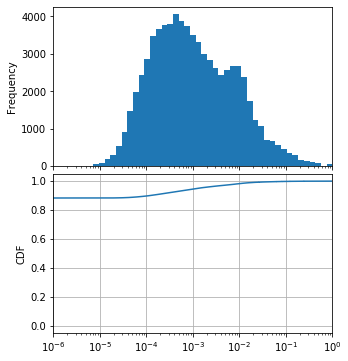

hwc Submissions by Subreddit hate by word count    0.000814
dtype: float64


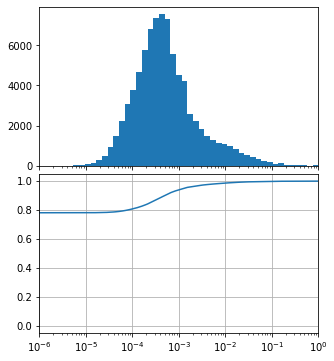

hwc Comments by Subreddit hate by word count    0.000432
dtype: float64


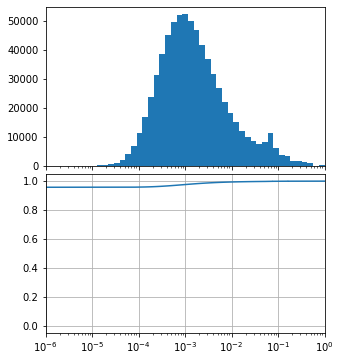

hwc Submissions by User hate by word count    0.001251
dtype: float64


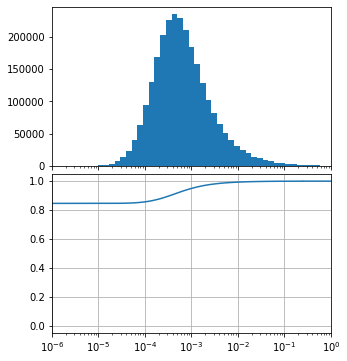

hwc Comments by User hate by word count    0.00055
dtype: float64


In [6]:
# FROM FEB 2016 to FEB 2018 
filenames = ['subredditbyhatebywordcountsubmissions',
            'subredditbyhatebywordcountcomments',
            'authorbyhatebywordcountsubmissions',
            'authorbyhatebywordcountcomments']
outputs = ['hwc Submissions by Subreddit', 'hwc Comments by Subreddit', 
          'hwc Submissions by User', 'hwc Comments by User', ]
df_x = ['Subreddit', 'Subreddit', 'User', 'User']
df_y = 'hate by word count'

label_x = 'Hate Word Level'
label_y = [True, False, False, False]

for i in range(len(filenames)):
    col_names = [df_x[i], df_y]
    df = read_csv(filenames[i], col_names)
    plot_hist_single_cdf(df, df_x, df_y, label_y=label_y[i], filename=outputs[i] + ' histcdf')
#     print(outputs[i], len(df.loc[df[df_y] == 0.0])/len(df)) # % of 0s
    print(outputs[i], df.loc[df[df_y] != 0.0].median()) # median

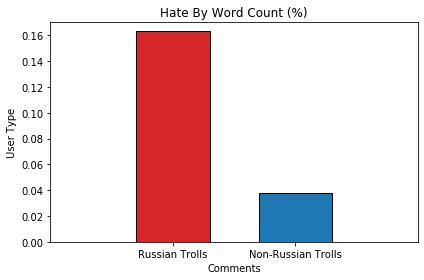

Comments
   type       hwc
 normal  0.038157
 troll  0.163647



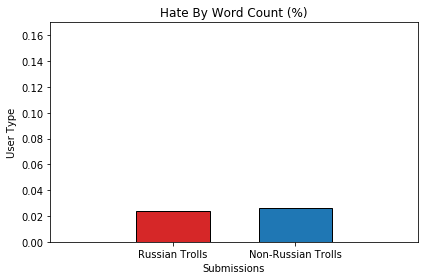

Submissions
   type       hwc
 normal  0.026275
 troll  0.024179



In [11]:
# FROM JAN 2016 - FEB 2018
filenames = ['hwciftrollcomments', 'hwciftrollsubmissions']
titles = ['Comments',
         'Submissions']
df_x = 'type'
df_y = 'hwc'
col_names = [df_x, df_y]
label_x = 'User Type'
label_y = 'Hate By Word Count (%)'
y_max = 0.17

for i in range(len(filenames)):
    df_hwc = read_csv(filenames[i], col_names)
    df_hwc[df_y] *= 100
    df_normal = df_hwc.loc[[0]]
    df_russian = df_hwc.loc[[1]]
    plot_russian_vs_normal_bar(df_russian, df_normal,
                               df_x, df_y, titles[i],
                               label_x, label_y, y_max=y_max)
    print(titles[i])
    print(df_normal.to_string(index=False))
    print(df_russian.to_string(index=False, header=False))
    print()

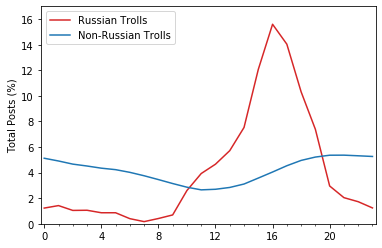

rth Submissions by Hour
Ks_2sampResult(statistic=0.5833333333333334, pvalue=0.0004056559340207839)


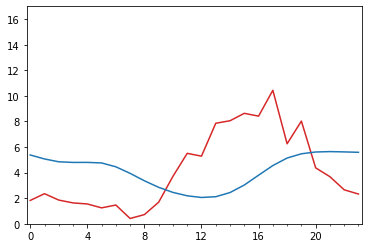

rth Comments by Hour
Ks_2sampResult(statistic=0.375, pvalue=0.06780335175136987)


In [18]:
russian_filenames = ['rthrussiansubmissions', 'rthrussiancomments']

normal_filenames = ['rthnormalsubmissions', 'rthnormalcomments']
outputs = ['rth Submissions by Hour', 'rth Comments by Hour']
df_x = 'hour of day'
df_y = 'count'
col_names = [df_x, df_y]
label_x = 'Post Hour (24h, Moscow GMT+3)'
label_y = 'Total Posts (%)'
y_min = 0
y_max = 17
has_legend = [True, False]
set_label_y = [True, False]

for i in range(len(russian_filenames)):
    df_russian = read_csv(russian_filenames[i], col_names)
    df_russian = to_moscow_time(df_russian, df_x)
    df_russian = df_russian.sort_values(df_x)
    df_russian = normalise_total(df_russian, df_y)
    
    df_normal = read_csv(normal_filenames[i], col_names)
    df_normal = to_moscow_time(df_normal, df_x)
    df_normal = df_normal.sort_values(df_x)
    df_normal = normalise_total(df_normal, df_y)  
    
    df_russian = convert_to_percentage(df_russian, df_y)
    df_normal = convert_to_percentage(df_normal, df_y)
    
    plot_russian_vs_normal_line([df_russian], [df_normal],
                                df_x, df_y, label_x, label_y, 
                                has_legend=has_legend[i], set_label_y=set_label_y[i], set_label_x=False,
                                y_min=y_min, y_max=y_max, loc="upper left", bbox_to_anchor=(0,1),
                               filename=outputs[i])
    
    print(outputs[i])
    print(ks_2samp(df_russian[df_y].tolist(), df_normal[df_y].tolist()))
    

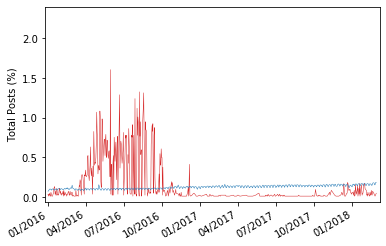

rtd Submissions by Date
Ks_2sampResult(statistic=0.6366837949617746, pvalue=4.440892098500626e-16)



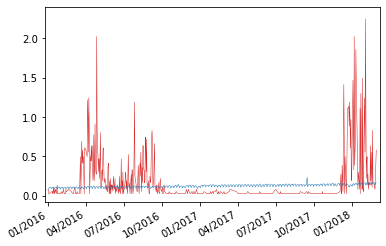

rtd Comments by Date
Ks_2sampResult(statistic=0.554548130703562, pvalue=8.428823913987535e-75)



In [17]:
russian_filenames = ['rtdrussiansubmissions', 'rtdrussiancomments']
normal_filenames = ['rtdnormalsubmissions', 'rtdnormalcomments']
outputs = ['rtd Submissions by Date', 'rtd Comments by Date']
df_x = 'date'
df_y = 'count'
col_names = [df_x, df_y]
label_x = 'Post Date (mm/yyyy)'
label_y = 'Total Posts (%)'
y_max = 2.4
has_legend = [True, False]
set_label_y = [True, False]

for i in range(len(russian_filenames)):
    df_russian = get_normalised_date_sorted_csv(russian_filenames[i], col_names)
    df_normal = get_normalised_date_sorted_csv(normal_filenames[i], col_names)
    
    df_russian = convert_to_percentage(df_russian, df_y)
    df_normal = convert_to_percentage(df_normal, df_y)
    
    plot_russian_vs_normal_line([df_russian], [df_normal],  
                                df_x, df_y, 
                                label_x, label_y,
                                is_date=True, has_legend=False,
                                linewidth=0.5, set_label_x=False, set_label_y=set_label_y[i],
                                y_max=y_max, loc="upper left", bbox_to_anchor=(1.1,1), filename=outputs[i])
    print(outputs[i])
    print(ks_2samp(df_russian[df_y].tolist(), df_normal[df_y].tolist()))
    print()

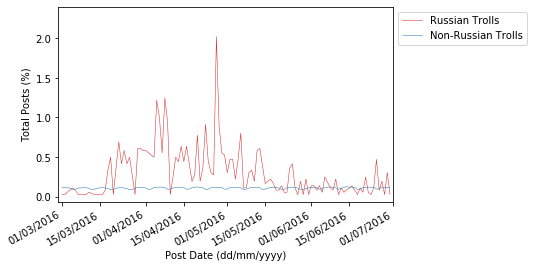

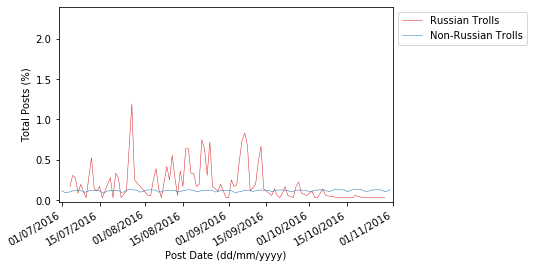

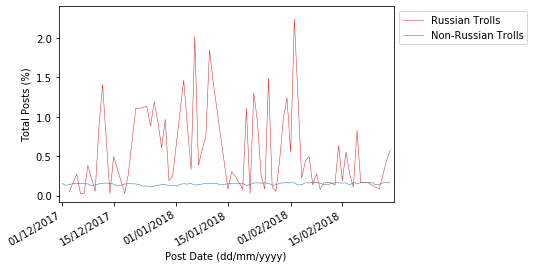

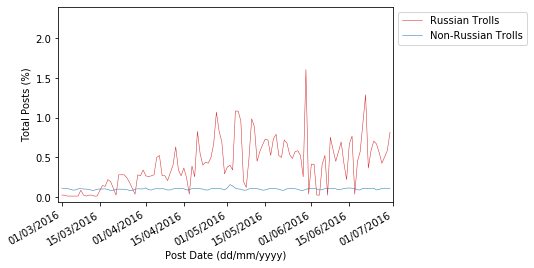

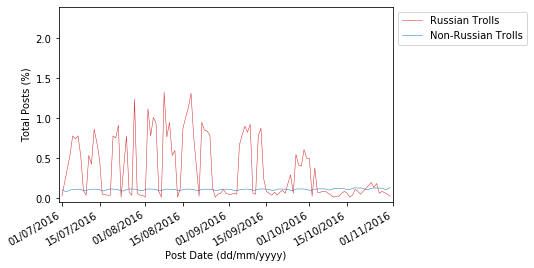

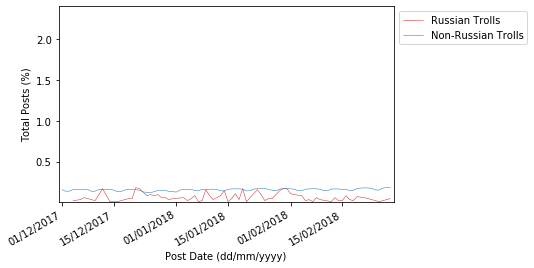

In [19]:
russian_filenames = ['rtdrussiancomments', 'rtdrussiansubmissions']
normal_filenames = ['rtdnormalcomments', 'rtdnormalsubmissions']
outputs_base = ['rtd Comments by Date',
          'rtd Submissions by Date']
outputs_ext = [' Mar 2016 - Jun 2016', 
             ' Jul 2016 - Oct 2016',
             ' Dec 2017 - Feb 2018']
start = ['20160301', '20160701', '20171201']
end = ['20160630', '20161031', '20180228']
df_x = 'date'
df_y = 'count'
col_names = [df_x, df_y]
label_x = 'Post Date (dd/mm/yyyy)'
label_y = 'Total Posts (%)'
y_max = 2.4

for i in range(len(russian_filenames)):
    df_russian = get_normalised_date_sorted_csv(russian_filenames[i], col_names)
    df_normal = get_normalised_date_sorted_csv(normal_filenames[i], col_names)
    
    df_russian = convert_to_percentage(df_russian, df_y)
    df_normal = convert_to_percentage(df_normal, df_y)
    
    for j in range(len(outputs_ext)):
        df_russian_by_period = df_russian.query(start[j] + ' <= date <= ' + end[j])
        df_normal_by_period = df_normal.query(start[j] + ' <= date <= ' + end[j])
        
        plot_russian_vs_normal_line([df_russian_by_period], [df_normal_by_period],  
                                    df_x, df_y, 
                                    label_x, label_y, 
                                    is_day_date=True,  
                                    linewidth=0.5, y_max=y_max, loc="upper left", filename=outputs_base[i] + outputs_ext[j])

/home/w/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/w/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


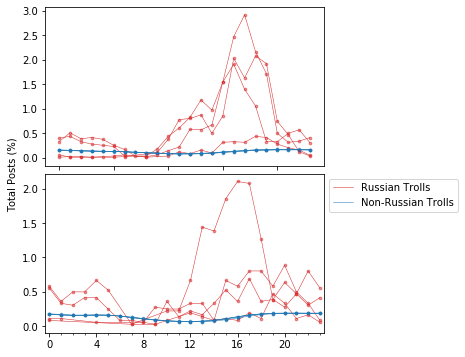

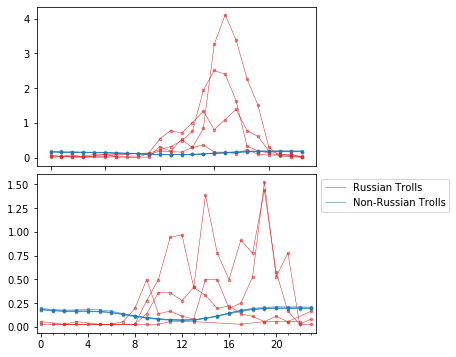

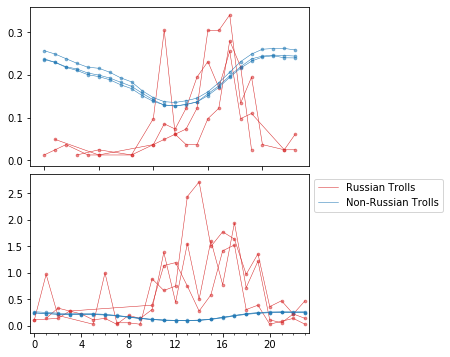

In [21]:
russian_filenames = ['rthmyrussiansubmissions', 'rthmyrussiancomments']
normal_filenames = ['rthmynormalsubmissions', 'rthmynormalcomments']
outputs_base = 'rth subcom by Hour'
outputs_ext = [' Mar 2016 - Jun 2016', 
             ' Jul 2016 - Oct 2016',
             ' Dec 2017 - Feb 2018']
start_years = [2016, 2016, 2017]
start_months = [3, 7, 12,]
end_years = [2016, 2016, 2018]
end_months = [6, 10, 2]

set_label_y = [True, False, False]

df_x = 'hmy'
df_y = 'count'
col_names = [df_x, df_y]
label_x = 'Post Hour (24h, Moscow GMT+3)'
label_y = 'Total Posts (%)'


df_russian_sub = get_normalised_hmy_sorted_csv(russian_filenames[0], col_names)
df_russian_com = get_normalised_hmy_sorted_csv(russian_filenames[1], col_names)

df_normal_sub = get_normalised_hmy_sorted_csv(normal_filenames[0], col_names)
df_normal_com = get_normalised_hmy_sorted_csv(normal_filenames[1], col_names)

df_russian_sub = convert_to_percentage(df_russian_sub, df_y)
df_russian_com = convert_to_percentage(df_russian_com, df_y)

df_normal_sub = convert_to_percentage(df_normal_sub, df_y)
df_normal_com = convert_to_percentage(df_normal_com, df_y)

for j in range(len(outputs_ext)):
    df_russian_sub_by_period = get_df_by_period(df_russian_sub, df_x, 
                                            start_years[j], start_months[j], 
                                            end_years[j], end_months[j])
    df_russian_com_by_period = get_df_by_period(df_russian_com, df_x, 
                                            start_years[j], start_months[j], 
                                            end_years[j], end_months[j])
    
    df_normal_sub_by_period = get_df_by_period(df_normal_sub, df_x, 
                                           start_years[j], start_months[j], 
                                            end_years[j], end_months[j])
    df_normal_com_by_period = get_df_by_period(df_normal_com, df_x, 
                                           start_years[j], start_months[j], 
                                            end_years[j], end_months[j])

    plot_russian_vs_normal_scatter([df_russian_sub_by_period, df_russian_com_by_period], 
                                   [df_normal_sub_by_period, df_normal_com_by_period],  
                                    'hour', df_y, 
                                    label_x, label_y, 
                                    has_legend=True, set_label_y = set_label_y[j], 
                                    set_label_x = False,
                                    linewidth=0.5, filename=outputs_base + outputs_ext[j])

In [ ]:
def create_scored_hate_wordcount(hate_filenames, score_filename, output_filenames, df_x, df_y):
    for i in range(len(hate_filenames)):
        df_hate = read_csv(hate_filenames[i], [df_x, df_y])
        df_score = read_csv(score_filename, [df_x, 'score'])

        df_hate = dict(zip(list(df_hate[df_x]), list(df_hate[df_y])))

        for j, row in df_score.iterrows():
            subreddit = row[df_x]
            hswc = row['score']

            if subreddit in df_hate:
                df_hate[subreddit] *= hswc       

        df_hate = pd.DataFrame.from_dict(df_hate, orient='index').reset_index()
        df_hate.columns = [df_x, df_y]
        df_hate = df_hate.sort_values(df_y, ascending=False)
        df_hate.to_csv(output_filenames[i], sep='\t', encoding='utf-8')

hate_filenames = ['filtered_authorbyhatebywordcountsubmissions',
                  'filtered_authorbyhatebywordcountcomments']
score_filename = 'authorbyscore'
output_filenames = ['authorbyscoredhatewordssubmissions', 'authorbyscoredhatewordscomments']
df_x = 'user'
df_y = 'hate score by word count'
create_scored_hate_wordcount(hate_filenames, score_filename, output_filenames, df_x, df_y)

hate_filenames = ['filtered_subredditbyhatebywordcountsubmissions',
                  'filtered_subredditbyhatebywordcountcomments']
score_filename = 'subredditbyscore'
output_filenames = ['subredditbyscoredhatewordssubmissions', 'subredditbyscoredhatewordscomments']
df_x = 'Subreddit'
df_y = 'hate score by word count'
create_scored_hate_wordcount(hate_filenames, score_filename, output_filenames, df_x, df_y)

In [22]:
# full period
filename = 'rtpostcountbycommentsrt'
df = read_csv(filename, ['author', 'count'])
print('trolls that commented:', len(df['author']))

rt_commenters = set(df['author'].tolist())

filename = 'rtpostcountbysubmissionsrt'
df = read_csv(filename, ['author', 'count'])
print('trolls that submitted', len(df['author']))

rt_submitters = set(df['author'].tolist())

rt_intersection = rt_commenters.intersection(rt_submitters)
print('intersection:', len(rt_intersection)) 

rt_comment_only = len(rt_commenters) - len(rt_intersection)
print('comment only:', rt_comment_only)
rt_submit_only = len(rt_submitters) - len(rt_intersection)
print('submit only:', rt_submit_only)

rt_total = len(rt_commenters) + len(rt_submitters) - len(rt_intersection)
print('total:', rt_total)
print('intersection %:', 100 * len(rt_intersection) / rt_total)
print('comment only %:', 100 * rt_comment_only / rt_total)
print('submit only %:', 100 * rt_submit_only / rt_total)

#######
print()
print()

filename = 'rtpostcountbycommentsn'
df = read_csv(filename, ['author', 'hwc'])
n_commenters = set(df['author'].tolist())
print('normals that commented:', len(n_commenters))

filename = 'rtpostcountbysubmissionsn'
df = read_csv(filename, ['author', 'hwc'])
n_submitters = set(df['author'].tolist())
print('normals that submitted', len(n_submitters))

n_intersection = n_commenters.intersection(n_submitters)
print('intersection:', len(n_intersection)) 

n_comment_only = len(n_commenters) - len(n_intersection)
print('comment only:', n_comment_only)
n_submit_only = len(n_submitters) - len(n_intersection)
print('submit only:', n_submit_only)

n_total = len(n_commenters) + len(n_submitters) - len(n_intersection)
print('total:', n_total)
print('intersection %:', 100 * len(n_intersection) / n_total)

print('comment only %:', 100 * n_comment_only / n_total)
print('submit only %:', 100 * n_submit_only / n_total)

trolls that commented: 53
trolls that submitted 123
intersection: 49
comment only: 4
submit only: 74
total: 127
intersection %: 38.58267716535433
comment only %: 3.1496062992125986
submit only %: 58.267716535433074


normals that commented: 17200208
normals that submitted 16554928
intersection: 10918487
comment only: 6281721
submit only: 5636441
total: 22836649
intersection %: 47.811248489215735
comment only %: 27.507192495711607
submit only %: 24.681559015072658


In [21]:
p = 0.95
table = [ [53, 123 ], 
                    [17200208, 16554928 ] ]
stat, p, dof, expected = chi2_contingency(table)
prob = 0.95
print("df", dof)
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    ('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

df 1
probability=0.950, critical=3.841, stat=29.764
Dependent (reject H0)
significance=0.050, p=0.000


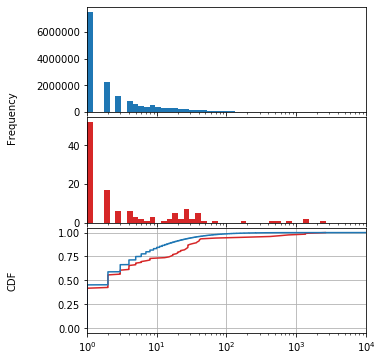

TypeError: list indices must be integers or slices, not float

In [25]:
filenames = [['rtpostcountbysubmissionsrt', 'rtpostcountbysubmissionsn'], 
             ['rtpostcountbycommentsrt', 'rtpostcountbycommentsn']]
outputs = ['rtpostcount Submissions', 'rtpostcount Comments']
df_x = 'author'
df_y = 'count'
col_names = [df_x, df_y]
label_x = 'Post Count'
label_y = 'Frequency'

has_legend = False
set_label_x = False
set_label_y = [True, False]

for i, f in enumerate(filenames):
    rt_df = read_csv(f[0], col_names)  
    n_df = read_csv(f[1], col_names)
       
    rt_df = rt_df.sort_values(df_y, ascending=False)
    n_df = n_df.sort_values(df_y, ascending=False)
    plot_hist_double_cdf(rt_df, n_df, df_x, df_y, label_x, label_y, x_min=1, x_max=10000, filename=outputs[i] + ' Russian Troll')
#     plot_hist(rt_df, df_x, df_y, label_x, label_y, x_min=1, x_max=10000, filename=o + ' Russian Troll')
#     plot_hist(n_df, df_x, df_y, label_x, label_y, x_min=1, x_max=10000, filename=o + ' Baseline')
#     plot_cdf_double(rt_df, n_df, df_x, df_y, label_x, log_scale=True, filename=o)    
    print(outputs[i/2])
    print(ks_2samp(rt_df[df_y].tolist(), n_df[df_y].tolist()))

In [ ]:
# get combined scores
df_x = 'author'
df_y = 'score'
col_names =  [df_x, df_y]
comments_df = read_csv('authorscorebycomments', col_names)
submissions_df = read_csv('authorscorebysubmissions', col_names)

combined_df = comments_df.groupby(df_x).sum().add(submissions_df.groupby(df_x).sum(), fill_value=0).reset_index()
combined_df.to_csv('combinedauthorscore', sep='\t', encoding='utf-8', index=False, header=False)

In [3]:
# get russian comment, submission and combined scores Feb 2016 - Feb 2018
df = read_csv('rtpostcountbycomments', ['author', 'hwc'])
rt_commenters = set(df['author'].tolist())

df = read_csv('rtpostcountbysubmissions', ['author', 'hwc'])
rt_submitters = set(df['author'].tolist())

rt_posters = rt_commenters.union(rt_submitters)

filenames = ['authorscorebycomments', 'authorscorebysubmissions', 'combinedauthorscore']
df_x = 'author'
df_y = 'score'

for i, f in enumerate(filenames):
    df = read_csv(filenames[i], [df_x, df_y])
    df = df.loc[df[df_x].isin(rt_posters)].sort_values(df_y, ascending=False)
    df.to_csv('rt'+filenames[i], sep='\t', encoding='utf-8', index=False, header=False)

In [54]:
rt_filenames = ['rtsubredditsaggregatesubmissionsrussian',
                'rtsubredditsaggregatecommentsrussian']
n_filenames = ['rtsubredditsaggregatesubmissionsnormal', 
               'rtsubredditsaggregatecommentsnormal']
col_names = ['subreddit', 'count']
post_type = ['submissions', 'comments']

for i in range(2):
    print(post_type[i].upper())
    rt_subreddits = set(read_csv(rt_filenames[i], col_names)['subreddit'].tolist())
    n_subreddits = set(read_csv(n_filenames[i], col_names)['subreddit'].tolist())
    intersection = rt_subreddits.intersection(n_subreddits)
    print('russian only:', len(rt_subreddits) - len(intersection))
    print(rt_subreddits - intersection)
    
    print()
    print('intersection:', len(intersection))
    print(intersection)
    print()


SUBMISSIONS
russian only: 7
{'BarnieSandlers', 'u_smoliangirl', 'MovieDownlodOnline', 'CaptainOnBoard', 'animalsbeingtrolled', 'u_failkate', 'democracysim'}

intersection: 708
{'UnsolvedMurders', 'SurpriseAppearances', 'TankPorn', 'Hillary2016', '90sHipHop', 'TheWeeknd', 'muhammadali', 'eu', 'Israel', 'hamsters', 'newhampshire', 'MakingaMurderer', 'socialism', 'cartoons', 'PINAC', 'itookapicture', 'fashion', 'EPL', 'television', 'ramadan', 'adventuretime', 'funny_cats', 'maryland', 'thick', 'PRINCE', 'psychology', 'GeniusDesign', 'internationalpolitics', 'olympics', 'holdmycatnip', 'georgetown', 'homeless', 'police', 'DIY', 'space', 'Marvel', 'Police_v_Video', 'Veterans', 'travel', 'Feminism', 'windowsphone', 'Virginia', 'Michigan', 'American_Politics', 'TalesFromThePharmacy', 'arrow', 'investigation', 'KidsBeingJerks', 'NKU', 'Health', 'cats', 'Mali', 'ImgurTroll', 'uofm', 'cnn', 'obama', 'slavery', 'oldschoolcreepy', 'BlackLivesMatter', 'Random_Acts_Of_Amazon', 'billboard', 'Fatherho

In [18]:
# FROM FEB 2016 - FEB 2018
filenames = ['subredditbyhatebywordcountsubmissions', 
             'subredditbyhatebywordcountcomments', 
             'authorbyhatebywordcountsubmissions', 
             'authorbyhatebywordcountcomments']
titles = ['Top 25 Most Hateful Subreddits by Submissions', 
          'Top 25 Most Hateful Subreddits by Comments', 
          'Top 25 Most Hateful Users by Submissions', 
          'Top 25 Most Hateful Users by Comments']
df_x = ['subreddit', 'subreddit', 'user', 'user']
df_y = 'hate score by word count'
label_x = ['Subreddits', 'Subreddits', 'Users', 'Users']
label_y = 'Hate Score by Word Count'

for i in range(len(filenames)):
    df = read_csv(filenames[i], [df_x[i], df_y])
    df = df.sort_values(df_y, ascending=False)
    df = df.iloc[:25]
    print(titles[i])
    print(df.to_string(index=False))

Top 25 Most Hateful Subreddits by Submissions
subreddit  hate score by word count
          kakao                       1.0
     NiggerJerk                       1.0
 CoDPeoplesArmy                       1.0
   askanasshole                       1.0
  Ikilledaroach                       1.0
       Kiseijuu                       1.0
   YourTheories                       1.0
    iamversmary                       1.0
  FallofSecrets                       1.0
    Purple_Fags                       1.0
        snutten                       1.0
    HeistMovies                       1.0
anthonyburleson                       1.0
        Saifman                       1.0
   DuerteQuotes                       1.0
    genderkurwa                       1.0
    rslashgavin                       1.0
       manasith                       1.0
TryMilkehSalban                       1.0
         urafag                       1.0
        hamaham                       1.0
        Chaalie                     

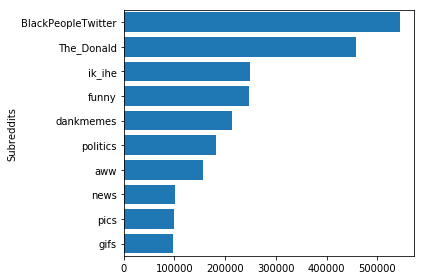

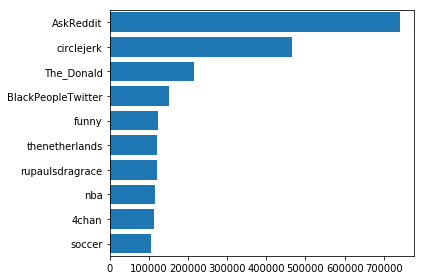

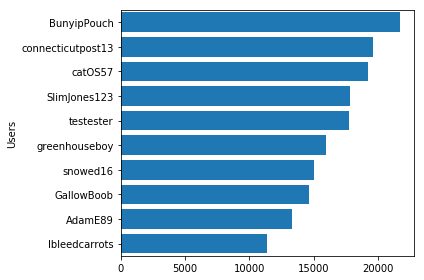

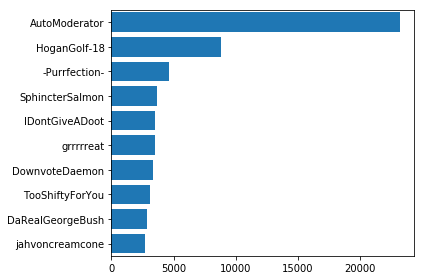

In [13]:
# FROM FEB 2016 - FEB 2018
filenames = ['inc_subredditbyscoredhatewordssubmissions', 
             'inc_subredditbyscoredhatewordscomments', 
             'inc_authorbyscoredhatewordssubmissions', 
             'inc_authorbyscoredhatewordscomments']
titles = ['Top 10 Highest Scoring Hateful Subreddits by Submissions', 
          'Top 10 Highest Scoring Hateful Subreddits by Comments', 
          'Top 10 Highest Scoring Hateful Users by Submissions', 
          'Top 10 Highest Scoring Hateful Users by Comments']
df_x = ['subreddit', 'subreddit', 'user', 'user']
df_y = 'hate score by word count'
label_y = ['Subreddits', 'Subreddits', 'Users', 'Users']
label_x = 'Hate Score by Word Count'
set_label_y = [True, False, True, False]

for i in range(len(filenames)):
    df = read_csv(filenames[i], [df_x[i], df_y])
    df = df.sort_values(df_y)
    df = df.iloc[-10:]
    plot_hbar(df, df_x[i], df_y, label_y[i], 
              set_label_y=set_label_y[i], filename=filenames[i] + " hbar")
#     print(titles[i])
#     print(df.to_string(index=False))

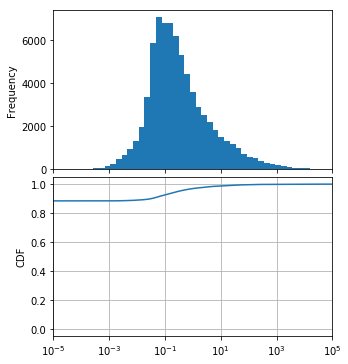

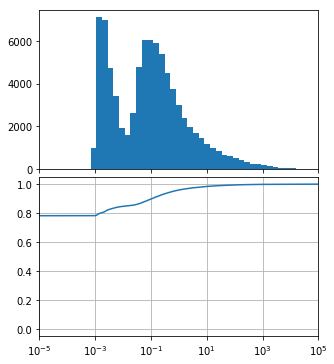

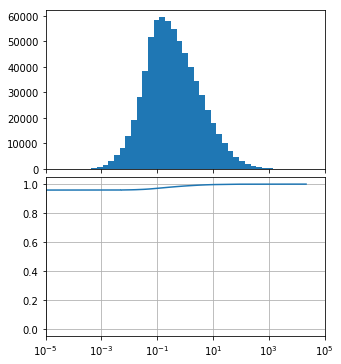

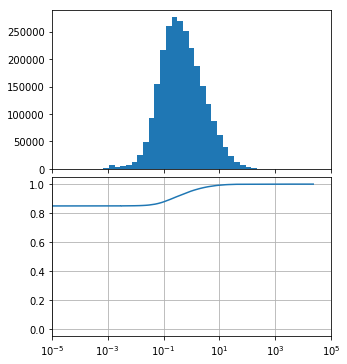

In [86]:
filenames = ['inc_subredditbyscoredhatewordssubmissions', 
             'inc_subredditbyscoredhatewordscomments', 
             'inc_authorbyscoredhatewordssubmissions', 
             'inc_authorbyscoredhatewordscomments']
outputs = ['hs Submissions by Subreddit', 'hs Comments by Subreddit', 
          'hs Submissions by User', 'hs Comments by User']
df_x = ['Subreddit', 'Subreddit', 'User', 'User']
df_y = 'hate by word count'

label_x = 'Hate Score'
label_y = [True, False, False, False]

for i in range(len(filenames)):
    col_names = [df_x[i], df_y]
    df = read_csv(filenames[i], col_names)
    plot_hist_single_cdf(df, df_x[i], df_y, label_y=label_y[i], x_min=0.00001, x_max=100000, filename=outputs[i] + ' histcdf')

In [ ]:
filenames = ['rtsubredditsaggregatesubmissionsnormal',
             'rtsubredditsaggregatesubmissionsrussian',
             'rtsubredditsaggregatecommentsnormal',
             'rtsubredditsaggregatecommentsrussian']
title_base = 'Top 25 Subreddits '
title_ext = ['for Non-Russian Troll Comments',
            'for Russian Troll Submissions',
            'for Non-Russian Troll Comments',
            'for Russian Troll Comments']
label_x = 'Subreddits'
label_y = 'Total Posts (%)'
col_names = [label_x, label_y]

set_y

total rtsubredditsaggregatesubmissionsnormal 229605488
total rtsubredditsaggregatesubmissionsrussian 8218
total rtsubredditsaggregatecommentsnormal 1950780082
total rtsubredditsaggregatecommentsrussian 3612


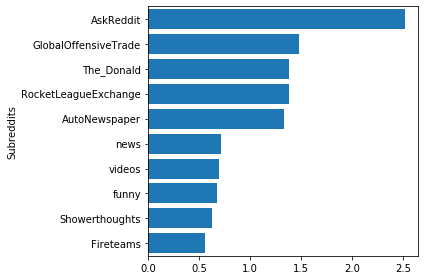

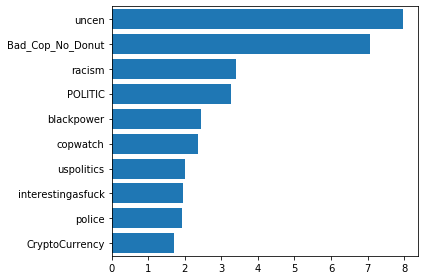

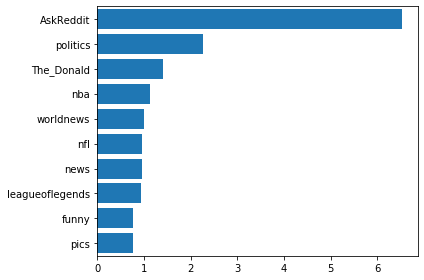

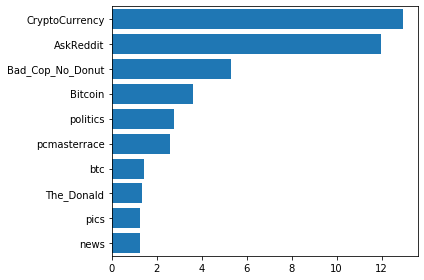

In [30]:
filenames = ['rtsubredditsaggregatesubmissionsnormal',
             'rtsubredditsaggregatesubmissionsrussian',
             'rtsubredditsaggregatecommentsnormal',
             'rtsubredditsaggregatecommentsrussian']
title_base = 'Top 10 Subreddits '
title_ext = ['for Non-Russian Troll Submissions',
            'for Russian Troll Submissions',
            'for Non-Russian Troll Comments',
            'for Russian Troll Comments']
label_x = 'Subreddits'
label_y = 'Total Posts (%)'
col_names = [label_x, label_y]

set_label_y = [True, False, False, False]

for i, f in enumerate(filenames):
    df = read_csv(f, col_names)
    df = df.sort_values(label_y)
    print('total', f,  df[label_y].sum())
    df = normalise_total(df, label_y)
    df = convert_to_percentage(df, label_y)
    df = df.iloc[-10:]
    
    plot_hbar(df, 
              label_x, label_y, 
              label_x, set_label_y=set_label_y[i], filename=title_base + title_ext[i])

In [78]:
filenames = ['rtsubredditscommentsrt1603',
             'rtsubredditscommentsrt1604',
             'rtsubredditscommentsrt1605',
             'rtsubredditscommentsrt1606',
             'rtsubredditscommentsrt1607',
             'rtsubredditscommentsrt1608',
             'rtsubredditscommentsrt1609',
             'rtsubredditscommentsrt1610',
             'rtsubredditscommentsrt1712',
             'rtsubredditscommentsrt1801',
             'rtsubredditscommentsrt1802']
title_base = 'Top 25 Subreddits for Russian Trolls to Comment in '
title_ext = ['March 2016',
            'April 2016',
            'May 2016',
            'June 2016',
            'July 2016',
            'August 2016',
            'September 2016',
            'October 2016',
            'December 2017',
            'January 2018',
            'February 2018']
label_x = 'Subreddits'
label_y = 'Total Posts (%)'
col_names = [label_x, label_y]
total_rt_comments = 3612

for i, f in enumerate(filenames):
    df = read_csv(f, col_names)
    df[label_y] /= total_rt_comments
    df = convert_to_percentage(df, label_y)
    df = df.sort_values(label_y, ascending=False) 
    df = df.iloc[:25]
    
#     plot_hbar(df, title_base + title_ext[i], 
#                       label_x, label_y, 
#                       label_x, label_y)
     
    print(title_base + title_ext[i])
    print(df.to_string(index=False))

Top 25 Subreddits for Russian Trolls to Comment in March 2016
Subreddits  Total Posts (%)
       AskReddit         2.048726
Bad_Cop_No_Donut         1.218162
           funny         0.304540
            news         0.249169
  Showerthoughts         0.221484
      The_Donald         0.193798
    pcmasterrace         0.166113
          Agario         0.110742
       Anarchism         0.110742
          videos         0.110742
   todayilearned         0.083056
         puppies         0.083056
             nyc         0.083056
       worldnews         0.083056
      circlejerk         0.055371
           arrow         0.055371
  watchpeopledie         0.055371
    Ask_Politics         0.055371
        pcgaming         0.055371
           linux         0.055371
        LazyCats         0.055371
             nfl         0.027685
        CatSlaps         0.027685
      FreeSpeech         0.027685
          pranks         0.027685
Top 25 Subreddits for Russian Trolls to Comment in April 201

In [111]:
filenames = ['rtsubredditssubmissionsrt1603',
             'rtsubredditssubmissionsrt1604',
             'rtsubredditssubmissionsrt1605',
             'rtsubredditssubmissionsrt1606',
             'rtsubredditssubmissionsrt1607',
             'rtsubredditssubmissionsrt1608',
             'rtsubredditssubmissionsrt1609',
             'rtsubredditssubmissionsrt1610',
             'rtsubredditssubmissionsrt1711',
             'rtsubredditssubmissionsrt1712',
             'rtsubredditssubmissionsrt1801',
             'rtsubredditssubmissionsrt1802']
title_base = 'Top 25 Subreddits in Russian Troll Submissions in '
title_ext = ['March 2016',
            'April 2016',
            'May 2016',
            'June 2016',
            'July 2016',
            'August 2016',
            'September 2016',
            'October 2016',
             'November 2017',
            'December 2017',
            'January 2018',
            'February 2018']
label_x = 'Subreddits'
label_y = 'Total Posts (%)'
col_names = [label_x, label_y]
total_rt_submissions = 8218

for i, f in enumerate(filenames):
    df = read_csv(f, col_names)
    df[label_y] /= total_rt_submissions
    df = convert_to_percentage(df, label_y)
    df = df.sort_values(label_y, ascending=False) 
    df = df.iloc[:25]
    
#     plot_hbar(df,  
#               label_x, label_y, 
#               label_x, label_y, 
#               title=title_base + title_ext[i])

    print(title_base + title_ext[i])
    print(df.to_string(index=False))

Top 25 Subreddits in Russian Troll Submissions in March 2016
Subreddits  Total Posts (%)
              uncen         0.535410
   Bad_Cop_No_Donut         0.511073
          AskReddit         0.255537
              funny         0.170358
                aww         0.133853
             videos         0.133853
             racism         0.133853
           LazyCats         0.121684
            puppies         0.121684
           copwatch         0.121684
               news         0.109516
      UpliftingNews         0.073010
       holdmycatnip         0.060842
         uspolitics         0.060842
     Showerthoughts         0.036505
           politics         0.024337
                WTF         0.024337
            history         0.024337
     syriancivilwar         0.024337
          worldnews         0.024337
ANormalDayInAmerica         0.024337
               cats         0.024337
          Anarchism         0.024337
    ProtectAndServe         0.024337
   WesternTerrorism    

In [ ]:
filenames = ['rtwordscommentsn1603',
             'rtwordscommentsn1604',
             'rtwordscommentsn1605',
             'rtwordscommentsn1606',
             'rtwordscommentsn1607',
             'rtwordscommentsn1608',
             'rtwordscommentsn1609',
             'rtwordscommentsn1610',
             'rtwordscommentsn1711',
             'rtwordscommentsn1712',
             'rtwordscommentsn1801',
             'rtwordscommentsn1802']
title_base = 'Top 25 Words used in Non-Russian Troll Comments in '
title_ext = ['March 2016',
            'April 2016',
            'May 2016',
            'June 2016',
            'July 2016',
            'August 2016',
            'September 2016',
            'October 2016',
             'November 2017',
            'December 2017',
            'January 2018',
            'February 2018']
label_x = 'Stemmed words'
label_y = 'Total Posts (%)'
col_names = [label_x, label_y]

for i, f in enumerate(filenames):
    df = read_csv(f, col_names)
    df = normalise_total(df, label_y)
    df = convert_to_percentage(df, label_y)
    df = df.sort_values(label_y, ascending=False)
    df = df.iloc[:25]
    
#     plot_hbar(df,  
#               label_x, label_y, 
#               label_x, label_y, 
#               title=title_base + title_ext[i])

    print(title_base + title_ext[i])
    print(df.to_string(index=False))

Top 25 Words used in Russian Troll Comments in March 2016
Stemmed words  Total Posts (%)
          you         2.405797
            i         2.260870
        ethan         1.594203
    bradberri         1.594203
       retard         1.217391
       faggot         1.188406
           he         1.072464
         have         0.985507
         what         0.985507
          cop         0.956522
        peopl         0.898551
        think         0.869565
       should         0.782609
        would         0.695652
           do         0.637681
         your         0.637681
          law         0.637681
           we         0.608696
          it'         0.608696
           hi         0.550725
         when         0.550725
       becaus         0.550725
          can         0.550725
           me         0.550725
        about         0.550725
Top 25 Words used in Russian Troll Comments in April 2016
Stemmed words  Total Posts (%)
            i         2.633099
          you   

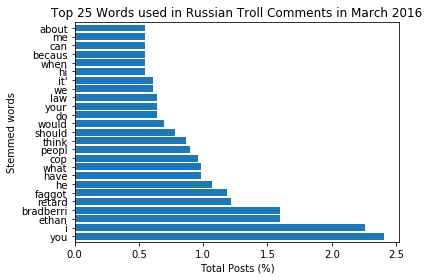

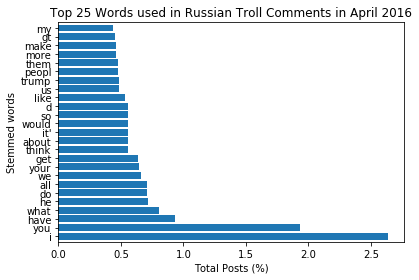

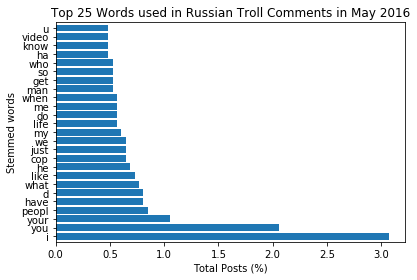

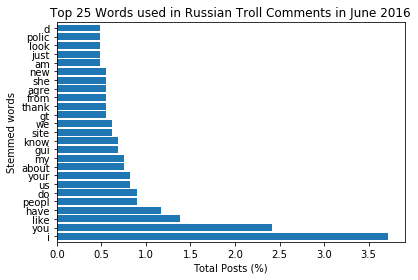

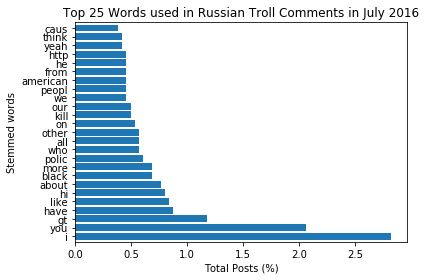

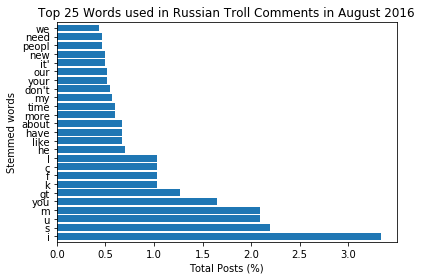

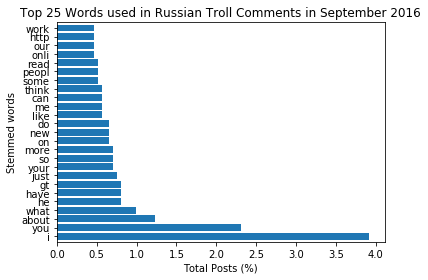

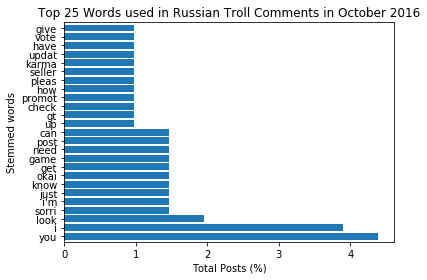

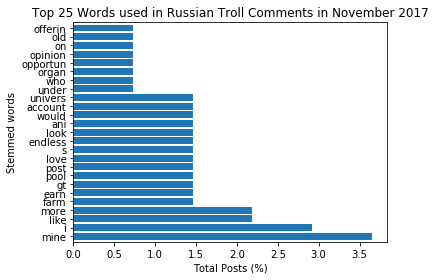

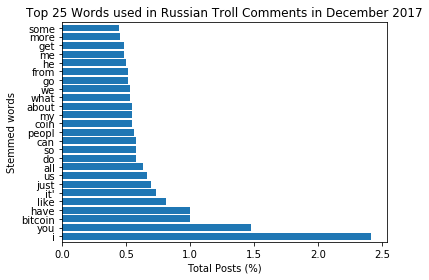

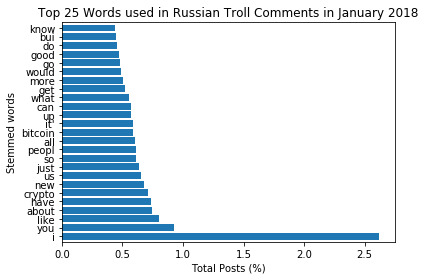

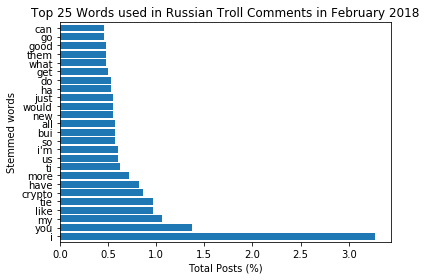

In [32]:
filenames = ['rtwordscommentsrt1603',
             'rtwordscommentsrt1604',
             'rtwordscommentsrt1605',
             'rtwordscommentsrt1606',
             'rtwordscommentsrt1607',
             'rtwordscommentsrt1608',
             'rtwordscommentsrt1609',
             'rtwordscommentsrt1610',
             'rtwordscommentsrt1711',
             'rtwordscommentsrt1712',
             'rtwordscommentsrt1801',
             'rtwordscommentsrt1802']
title_base = 'Top 25 Words used in Russian Troll Comments in '
title_ext = ['March 2016',
            'April 2016',
            'May 2016',
            'June 2016',
            'July 2016',
            'August 2016',
            'September 2016',
            'October 2016',
             'November 2017',
            'December 2017',
            'January 2018',
            'February 2018']
label_x = 'Stemmed words'
label_y = 'Total Posts (%)'
col_names = [label_x, label_y]

for i, f in enumerate(filenames):
    df = read_csv(f, col_names)
    df = normalise_total(df, label_y)
    df = convert_to_percentage(df, label_y)
    df = df.sort_values(label_y, ascending=False)
    df = df.iloc[:25]
    
    plot_hbar(df,  
              label_x, label_y, 
              label_x, label_y, 
              title=title_base + title_ext[i])

    print(title_base + title_ext[i])
    print(df.to_string(index=False))

In [109]:
filenames = ['rtwordssubmissionsn1603',
             'rtwordssubmissionsn1604',
             'rtwordssubmissionsn1605',
             'rtwordssubmissionsn1606',
             'rtwordssubmissionsn1607',
             'rtwordssubmissionsn1608',
             'rtwordssubmissionsn1609',
             'rtwordssubmissionsn1610',
             'rtwordssubmissionsn1711',
             'rtwordssubmissionsn1712',
             'rtwordssubmissionsn1801',
             'rtwordssubmissionsn1802']
title_base = 'Top 25 Words used in Non-Russian Troll Submissions in '
title_ext = ['March 2016',
            'April 2016',
            'May 2016',
            'June 2016',
            'July 2016',
            'August 2016',
            'September 2016',
            'October 2016',
             'November 2017',
            'December 2017',
            'January 2018',
            'February 2018']
label_x = 'Stemmed words'
label_y = 'Total Posts (%)'
col_names = [label_x, label_y]

for i, f in enumerate(filenames):
    df = read_csv(f, col_names)
    df = df.sort_values(label_y, ascending=False)
    df = normalise_total(df, label_y)
    df = convert_to_percentage(df, label_y)
    df = df.iloc[:25]
    
#     plot_hbar(df,  
#               label_x, label_y, 
#               label_x, label_y, 
#               title=title_base + title_ext[i])

    print(title_base + title_ext[i])
    print(df.to_string(index=False))

Top 25 Words used in Non-Russian Troll Submissions in March 2016
Stemmed words  Total Posts (%)
           i         3.055588
          my         1.082890
         you         0.986743
        have         0.832153
        http         0.802137
          me         0.607088
          so         0.550411
          do         0.495190
        what         0.489480
         get         0.459840
        like         0.452992
         i'm         0.449837
        just         0.449222
       delet         0.431758
        from         0.426181
         can         0.414659
         all         0.398365
          us         0.392426
       about         0.370649
          we         0.368531
          up         0.364607
       would         0.350890
         out         0.349770
          on         0.340338
        your         0.338493
Top 25 Words used in Non-Russian Troll Submissions in April 2016
Stemmed words  Total Posts (%)
           i         3.115310
          my         1.09777

In [67]:
filenames = ['rtwordssubmissionsrt1603',
             'rtwordssubmissionsrt1604',
             'rtwordssubmissionsrt1605',
             'rtwordssubmissionsrt1606',
             'rtwordssubmissionsrt1607',
             'rtwordssubmissionsrt1608',
             'rtwordssubmissionsrt1609',
             'rtwordssubmissionsrt1610',
             'rtwordssubmissionsrt1712',
             'rtwordssubmissionsrt1801',
             'rtwordssubmissionsrt1802']
title_base = 'Top 25 Words used in Russian Troll Submissions in '
title_ext = ['March 2016',
            'April 2016',
            'May 2016',
            'June 2016',
            'July 2016',
            'August 2016',
            'September 2016',
            'October 2016',
            'December 2017',
            'January 2018',
            'February 2018']
label_x = 'Stemmed words'
label_y = 'Total Posts (%)'
col_names = [label_x, label_y]

for i, f in enumerate(filenames):
    df = read_csv(f, col_names)
    df = df.sort_values(label_y, ascending=False)
    df = normalise_total(df, label_y)
    df = convert_to_percentage(df, label_y)
    df = df.iloc[:25]
    
#     plot_hbar(df,  
#               label_x, label_y, 
#               label_x, label_y, 
#               title=title_base + title_ext[i])

    print(title_base + title_ext[i])
    print(df.to_string(index=False))

Top 25 Words used in Russian Troll Submissions in March 2016
Stemmed words  Total Posts (%)
         you         1.559117
         cop         1.472499
       polic         1.212646
          do         0.866176
        what         0.822867
         man         0.822867
         cat         0.736249
           i         0.736249
           s         0.606323
         how         0.606323
       about         0.606323
       think         0.563014
       after         0.519706
          us         0.519706
        kill         0.519706
        your         0.519706
          me         0.476397
          hi         0.476397
         bad         0.433088
       charg         0.433088
        just         0.433088
       offic         0.433088
       puppi         0.433088
       world         0.389779
         her         0.389779
Top 25 Words used in Russian Troll Submissions in April 2016
Stemmed words  Total Posts (%)
       black         1.281243
         cop         1.249737
      

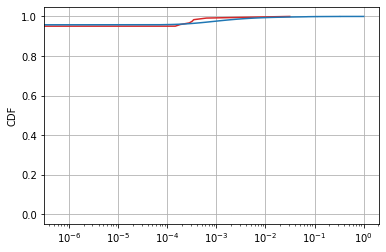

Hate by Word Count Submissions x2 CDF
Ks_2sampResult(statistic=0.02073220757961347, pvalue=0.9999999992001246)


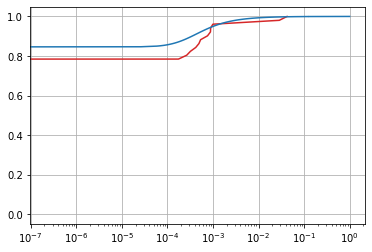

Hate by Word Count Comments x2 CDF
Ks_2sampResult(statistic=0.10203690178644731, pvalue=0.6511080151435096)


In [34]:
filenames = [['rtauthorbyhatebywordcountsubmissions',
            'nauthorbyhatebywordcountsubmissions'],
            ['rtauthorbyhatebywordcountcomments',
            'nauthorbyhatebywordcountcomments']]
outputs = ['Hate by Word Count Submissions x2 CDF', 'Hate by Word Count Comments x2 CDF']

df_x = 'author'
df_y = 'hwc'
label_x = 'Hate Word Level'
label_y = 'Frequency'
col_names = [df_x, df_y]

set_label_y = [True, False]

for i, f in enumerate(filenames):
    russian = read_csv(f[0], col_names)
    normal = read_csv(f[1], col_names)
    
    plot_cdf_double(russian, normal, df_x, df_y, label_x, 
                    has_legend=False, set_label_x = False, set_label_y = set_label_y[i],
                    log_scale=True, filename=outputs[i])    
    print(outputs[i])
    print(ks_2samp(russian[df_y].tolist(), normal[df_y].tolist()))

In [ ]:
filename_base = 'rtwordcount'
filename_type = ['submissions', 'comments']
filename_date = ['1603', '1604','1605','1606','1607','1608','1609','1610', 
                 '1711', '1712', '1801', '1802']
output = ['rtwordcountsubmissions', 'rtwordcountcomments']

rt_total = 0
n_total = 0
df_x = 'type'
df_y = 'wc'
for i, t in enumerate(filename_type):
    for d in filename_date:
        df = read_csv(filename_base + t + d, [df_x, df_y])
        n_total += df.iloc[0][df_y]
        rt_total += df.iloc[1][df_y]

    with open(output[i], 'w') as f:
        f.write('n' + '\t' + str(n_total) + '\n')
        f.write('rt' + '\t' + str(rt_total))
    
    print(n_total)
    print(rt_total)
    
    n_total = 0
    rt_total = 0

In [36]:
def create_normalised_freq_by_date_files(filename_base,
                                        filename_type,
                                        filename_date,
                                        dates,
                                        output_base,
                                        output_exts,
                                        categories,
                                        categories_total):
    df_x = 'categories'
    df_y = 'frequency'
    for i, t in enumerate(filename_type):
        for d in filename_date:
            df = read_csv(filename_base + t + d, [df_x, df_y])
        
            for c in categories:
                freq = df.loc[df[df_x] == c]
                if len(freq) == 0:
                    normalised = 0.0
                else: 
                    normalised = freq[df_y].values[0] / categories_total[i]

                date = str(d)[2:] + '-' + '20' + str(d)[:2]

                output_ext = output_exts[dates[d]]
            
                print(d, c, normalised)
                with open(output_base[i] + '_' + c + output_ext, 'a') as f:
                        f.write(date + '\t' + str(normalised) + '\n')
                        
filename_base = 'rtwords'
filename_type = ['submissionsrt', 'commentsrt']
filename_date = ['1603', '1604','1605','1606','1607','1608','1609','1610',
                '1711', '1712', '1801', '1802']
dates = {'1603':0, '1604':0, '1605':0, '1606':0, 
         '1607':0, '1608':0, '1609':0, '1610':0,
         '1711':1, '1712':1, '1801':1, '1802':1}
output_base = ['rtwordcountsubmissions', 'rtwordcountcomments']
output_exts = ['_1', '_2']
words = ['cop', 'polic', 'policeman', 'black', 
         'donald', 'trump', 'hillari', 'clinton', 'berni', 'sander', 'obama',
         'token', 'coin', 'crypto', 'cryptocurr', 'bitcoin', 'blockchain']
rt_words_total = [89335, 66420] 
create_normalised_freq_by_date_files(filename_base, filename_type, 
                                     filename_date, dates, 
                                     output_base, output_exts,
                                    words, rt_words_total)


1603 cop 0.00038058991436726926
1603 polic 0.000313426988302457
1603 policeman 0.0
1603 black 0.00010074438909721834
1603 donald 0.0
1603 trump 5.596910505401019e-05
1603 hillari 1.1193821010802037e-05
1603 clinton 4.477528404320815e-05
1603 berni 2.2387642021604074e-05
1603 sander 3.3581463032406114e-05
1603 obama 3.3581463032406114e-05
1603 token 0.0
1603 coin 0.0
1603 crypto 0.0
1603 cryptocurr 0.0
1603 bitcoin 0.0
1603 blockchain 0.0
1604 cop 0.0013320647002854425
1604 polic 0.001220126490177422
1604 policeman 2.2387642021604074e-05
1604 black 0.0013656461633178485
1604 donald 0.0002686517042592489
1604 trump 0.0006716292606481222
1604 hillari 0.000313426988302457
1604 clinton 0.000570884871550904
1604 berni 0.0001791011361728326
1604 sander 0.00027984552527005095
1604 obama 0.0003358146303240611
1604 token 0.0
1604 coin 0.0
1604 crypto 0.0
1604 cryptocurr 0.0
1604 bitcoin 0.0
1604 blockchain 0.0
1605 cop 0.0017574298986959198
1605 polic 0.001488778194436671
1605 policeman 0.0
1605

In [78]:
def create_grouped_normalised_freq_by_date_files(filename_base,
                                                 filename_type,
                                                 filename_date,
                                                 dates,
                                                 output_base,
                                                 output_exts,
                                                 categories,
                                                 categories_total):
    df_x = 'categories'
    df_y = 'frequency'
    for i, t in enumerate(filename_type):
        for d in filename_date:
            df = read_csv(filename_base + t + d, [df_x, df_y])
            
            for group, cat in categories.items():
                cat_normalised = 0.0
                for subcat in cat:
                    freq = df.loc[df[df_x] == subcat]
                    
                    if len(freq) != 0:
                        cat_normalised += (freq[df_y].values[0] / categories_total[i])
                    
                    date = str(d)[2:] + '-' + '20' + str(d)[:2]

                    output_ext = output_exts[dates[d]]

                with open(output_base[i] + '_' + group + output_ext, 'a') as f:
                    f.write(date + '\t' + str(cat_normalised) + '\n')
                        
filename_base = 'rtwords'
filename_type = ['submissionsrt', 'commentsrt']
filename_date = ['1603', '1604','1605','1606','1607','1608','1609','1610',
                '1711', '1712', '1801', '1802']
dates = {'1603':0, '1604':0, '1605':0, '1606':0, 
         '1607':0, '1608':0, '1609':0, '1610':0,
         '1711':1, '1712':1, '1801':1, '1802':1}
output_base = ['rtwordcountsubmissions', 'rtwordcountcomments']
output_exts = ['_1', '_2']
words = {'Race':['cop', 'polic', 'policeman', 'black'],
         'US Politics':['donald', 'trump', 'hillari', 'clinton', 'berni', 'sander', 'obama'], 
         'Cryptocurrencies':['token', 'coin', 'crypto', 'cryptocurr', 'bitcoin', 'blockchain']}
rt_words_total = [89335, 66420] 
create_grouped_normalised_freq_by_date_files(filename_base, filename_type, 
                                     filename_date, dates, 
                                     output_base, output_exts,
                                    words, rt_words_total)


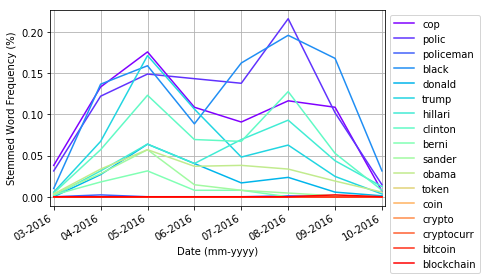

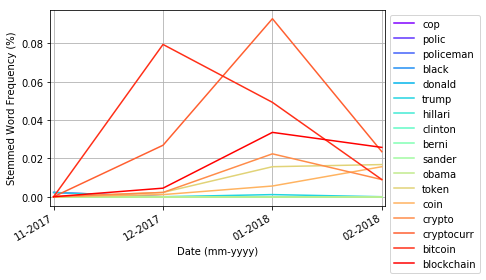

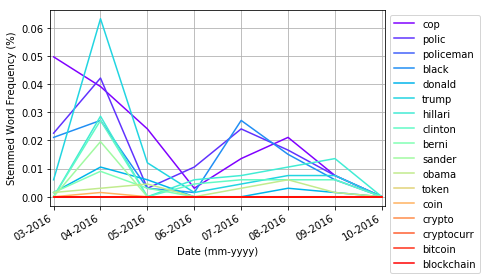

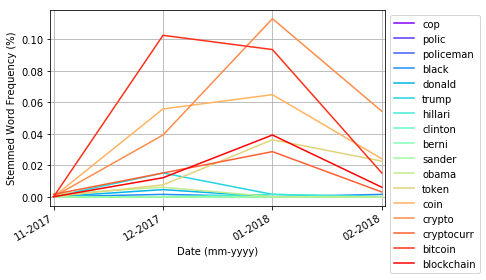

In [196]:
def get_title(filename_type, dates):
    return 'Frequency of ' + filename_type.title() + ' in ' + dates
            
filename_base = 'rtwordcount'
filename_type = ['submissions', 'comments']
filename_words = ['cop', 'polic', 'policeman', 'black', 
                 'donald', 'trump', 'hillari', 'clinton', 'berni', 'sander', 'obama',
                 'token', 'coin', 'crypto', 'cryptocurr', 'bitcoin', 'blockchain']
filename_exts = ['_1', '_2']

dates = ['March 2016 to October 2016', 
        'November 2017 to February 2018']
df_x = 'my'
df_y = 'norm_freq'
label_x = 'Date (mm-yyyy)'
label_y = 'Stemmed Word Frequency (%)'
col_names = [df_x, df_y]

for i, t in enumerate(filename_type):
    for e, d in zip(filename_exts, dates): 
        dfs = []
        
        f_part = filename_base + t + '_'
        for w in filename_words:
            filename = f_part + w + e 
            df = get_my_csv(filename, col_names)
            df[df_y] *= 100 
            dfs.append(df)
            
        plot_lines(dfs, df_x, df_y, 
                   label_x, label_y, filename_words, 
                   filename=get_title(t, d))
    
        
    
        

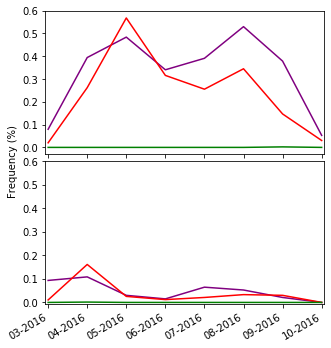

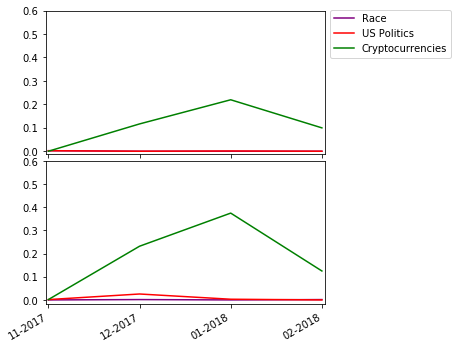

In [81]:
def get_title(filename_type, dates):
    return 'Frequency of ' + filename_type.title() + ' in ' + dates
            
filename_base = 'rtwordcount'
filename_type = ['submissions', 'comments']
filename_groups = ['Race', 'US Politics', 'Cryptocurrencies']
filename_exts = ['_1', '_2']

dates = ['March 2016 to October 2016', 
        'November 2017 to February 2018']
df_x = 'my'
df_y = 'norm_freq'
label_x = 'Date (mm-yyyy)'
label_y = 'Frequency (%)'
col_names = [df_x, df_y]
has_legend = [False, True]
set_y_label = [True, False]

for i, (d, e) in enumerate(zip(dates, filename_exts)):
    dfs = []
    for t in filename_type: 
        dfs_part = []
        
        f_part = filename_base + t + '_'
        for g in filename_groups:
            filename = f_part + g + e 
            df = get_my_csv(filename, col_names)
            df[df_y] *= 100 
            dfs_part.append(df)
            
        dfs.append(dfs_part)
    
    plot_lines(dfs, df_x, df_y, 
           label_x, label_y, filename_groups, 
           has_legend=has_legend[i], set_x_label = False, set_y_label = set_y_label[i],
           filename=get_title('Grouped Words ' + t, d), y_max=0.6, bbox_to_anchor=(1,1.04), 
               colours=['purple', 'red','green'])

In [57]:
filename_base = 'rtsubreddits'
filename_type = ['submissionsrt', 'commentsrt']
filename_date = ['1603', '1604','1605','1606','1607','1608','1609','1610',
                '1711', '1712', '1801', '1802']
dates = {'1603':0, '1604':0, '1605':0, '1606':0, 
         '1607':0, '1608':0, '1609':0, '1610':0,
         '1711':1, '1712':1, '1801':1, '1802':1}
output_base = ['rtsubredditssubmissions', 'rtsubredditscomments']
output_exts = ['_1', '_2']
subreddits = ['racism', 'blackpower', 'blackfellas', 'AfricanAmerican',
              'copwatch', 'Bad_Cop_No_Donut', 'Police_v_Video', 'police',
              'education', 'humanrights', 'worldnews', 'news', 'economy',  
              'politics', 'The_Donald', 'PoliticalDiscussion', 'POLITIC', 'uspolitics', 
              'HillaryForPrison', 'Republican', 'AmericanPolitics', 'PoliticalHumor',
              'BitcoinAll', 'ethtrader', 'CryptoCurrencies', 'BlockChain', 'btc', 'Bitcoin', 'CryptoCurrency']

rt_submissioncomment_total = [8218, 3612] 
create_normalised_freq_by_date_files(filename_base, filename_type, 
                                     filename_date, dates, 
                                     output_base, output_exts,
                                     subreddits, rt_submissioncomment_total)


1603 racism 0.0013385251886103675
1603 blackpower 0.0
1603 blackfellas 0.0
1603 AfricanAmerican 0.00012168410805548795
1603 copwatch 0.0012168410805548796
1603 Bad_Cop_No_Donut 0.005110732538330494
1603 Police_v_Video 0.0
1603 police 0.0
1603 education 0.0
1603 humanrights 0.0
1603 worldnews 0.0002433682161109759
1603 news 0.0010951569724993917
1603 economy 0.0
1603 politics 0.0002433682161109759
1603 The_Donald 0.00012168410805548795
1603 PoliticalDiscussion 0.00012168410805548795
1603 POLITIC 0.0
1603 uspolitics 0.0006084205402774398
1603 HillaryForPrison 0.0
1603 Republican 0.0
1603 AmericanPolitics 0.0
1603 PoliticalHumor 0.00012168410805548795
1603 BitcoinAll 0.0
1603 ethtrader 0.0
1603 CryptoCurrencies 0.0
1603 BlockChain 0.0
1603 btc 0.0
1603 Bitcoin 0.0
1603 CryptoCurrency 0.0
1604 racism 0.006205889510829885
1604 blackpower 0.0008517887563884157
1604 blackfellas 0.0
1604 AfricanAmerican 0.0004867364322219518
1604 copwatch 0.003042102701387199
1604 Bad_Cop_No_Donut 0.0152105135

In [79]:
filename_base = 'rtsubreddits'
filename_type = ['submissionsrt', 'commentsrt']
filename_date = ['1603', '1604','1605','1606','1607','1608','1609','1610',
                '1711', '1712', '1801', '1802']
dates = {'1603':0, '1604':0, '1605':0, '1606':0, 
         '1607':0, '1608':0, '1609':0, '1610':0,
         '1711':1, '1712':1, '1801':1, '1802':1}
output_base = ['rtsubredditssubmissions', 'rtsubredditscomments']
output_exts = ['_1', '_2']
subreddits = {'Race':['racism', 'blackpower', 'blackfellas', 'AfricanAmerican',
              'copwatch', 'Bad_Cop_No_Donut', 'Police_v_Video', 'police'],
              'International Affairs':['education', 'humanrights', 'worldnews', 'news', 'economy'],  
              'US Politics':['politics', 'The_Donald', 'PoliticalDiscussion', 'POLITIC', 'uspolitics', 
              'HillaryForPrison', 'Republican', 'AmericanPolitics', 'PoliticalHumor'],
              'Cryptocurrencies':['BitcoinAll', 'ethtrader', 'CryptoCurrencies', 'BlockChain', 'btc', 'Bitcoin', 'CryptoCurrency']}

rt_submissioncomment_total = [8218, 3612] 
create_grouped_normalised_freq_by_date_files(filename_base, filename_type, 
                                     filename_date, dates, 
                                     output_base, output_exts,
                                     subreddits, rt_submissioncomment_total)


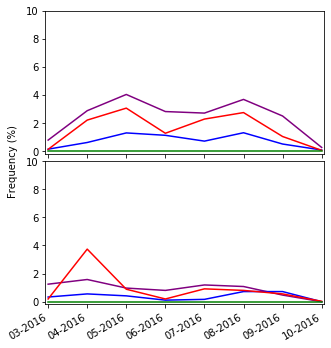

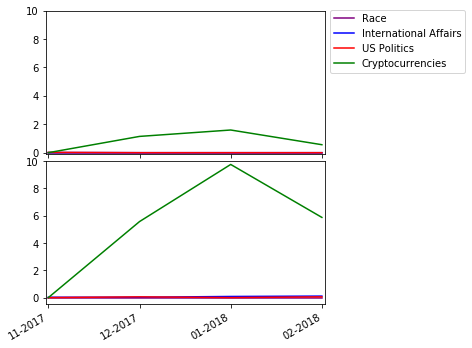

In [80]:
def get_title(filename_type, dates):
    return 'Frequency of ' + filename_type.title() + ' in ' + dates

filename_base = 'rtsubreddits'
filename_type = ['submissions', 'comments']
filename_subreddits = ['Race', 'International Affairs', 'US Politics', 'Cryptocurrencies']
filename_exts = ['_1', '_2']

outputs = ['Grouped Subreddits by Submissions', 'Grouped Subreddits by Comments']
dates = ['March 2016 to October 2016', 
        'November 2017 to February 2018']
df_x = 'my'
df_y = 'norm_freq'
label_x = 'Date (mm-yyyy)'
label_y = 'Frequency (%)'
col_names = [df_x, df_y]
has_legend = [False, True]
set_y_label = [True, False]

for i, (d, e) in enumerate(zip(dates, filename_exts)):
    dfs = []
    for t in filename_type: 
        dfs_part = []
        
        f_part = filename_base + t + '_'
        for s in filename_subreddits:
            filename = f_part + s + e 
            df = get_my_csv(filename, col_names)
            df[df_y] *= 100 
            dfs_part.append(df)
            
        dfs.append(dfs_part)
    
    plot_lines(dfs, df_x, df_y, 
           label_x, label_y, filename_subreddits, 
           has_legend=has_legend[i], set_x_label = False, set_y_label = set_y_label[i],
           filename=get_title(outputs[i], d), y_max=10, bbox_to_anchor=(1,1.04), colours=['purple','blue','red','green'])
        